In [1]:
import h5py
import numpy as np
import keras
import tensorflow as tf
import pandas as pd


np.random.seed(617)

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras import regularizers

from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

from clr_callback import CyclicLR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


from time import time

import matplotlib.pyplot as plt


/home/danielchan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

1.8.0
2.2.0


In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

In [4]:
def train_model(train_data,train_labels,validation_data,validation_labels,
                num_classes,nb_epoch=50,batch=512, weights=None):
    nb_train_samples = train_data.shape[0]

    CLR = True
    
    t_labels = keras.utils.to_categorical(train_labels, num_classes=num_classes)
    v_labels = keras.utils.to_categorical(validation_labels, num_classes=num_classes)


    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))

    #model.add(Dense(4096, activation='relu'))
    model.add(Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.0007)))
    #model.add(Dropout(0.8))
    model.add(BatchNormalization())

    #model.add(Dense(512, activation='relu'))
    #model.add(BatchNormalization())


    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=SGD(momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy']) 

    if (CLR):
        clr = CyclicLR(base_lr=1e-4, max_lr=1e-3,
                       step_size=1*np.ceil(train_data.shape[0]/batch), mode='triangular')
        callbacks_list = [clr] 

    history = model.fit(train_data, t_labels,
              epochs=nb_epoch, batch_size=batch,
              validation_data=(validation_data, v_labels), class_weight=weights,
              callbacks=callbacks_list,
              verbose=0)
    return model,history

In [5]:
def history_plot(history):

    %matplotlib inline

#_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.tight_layout()
    ax1.grid(True)
    ax2.grid(True)
#    ax1.set_yscale("log", nonposy='clip')
#    ax2.set_yscale("log", nonposy='clip')

    
    
    
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='lower right')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper right')

    plt.show()

    return

processing  VGG16
(5000, 7, 7, 512)
(5000,)
(600, 7, 7, 512)
(600,)
3
{0: 1.21300339640951, 1: 0.7026419336706015, 2: 1.3290802764486975}
Training Time:  65.68667984008789


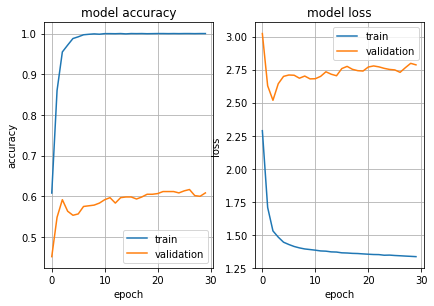

processing  RES50
(5000, 7, 7, 2048)
(5000,)
(600, 7, 7, 2048)
(600,)
3
{0: 1.21300339640951, 1: 0.7026419336706015, 2: 1.3290802764486975}
Training Time:  188.5244116783142


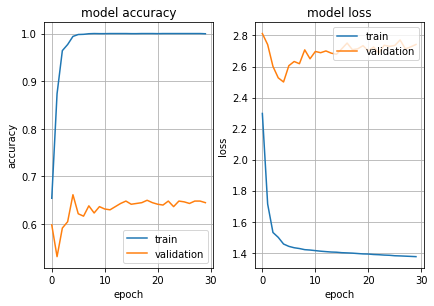

processing  XCP
(5000, 10, 10, 2048)
(5000,)
(600, 10, 10, 2048)
(600,)
3
{0: 1.21300339640951, 1: 0.7026419336706015, 2: 1.3290802764486975}
Training Time:  391.7152817249298


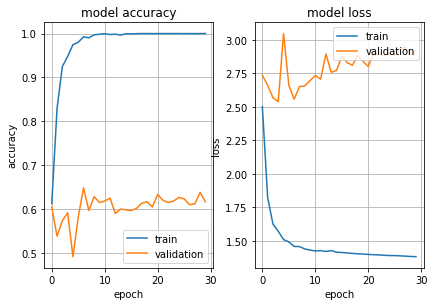

processing  IRV2
(5000, 8, 8, 1536)
(5000,)
(600, 8, 8, 1536)
(600,)
3
{0: 1.21300339640951, 1: 0.7026419336706015, 2: 1.3290802764486975}
Training Time:  198.44216918945312


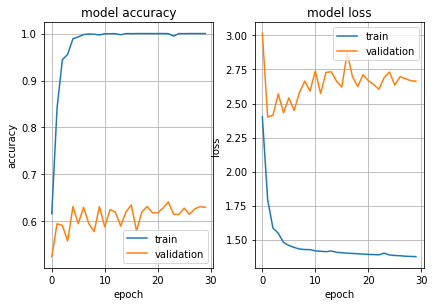

In [6]:
models = ['VGG16','RES50', 'XCP','IRV2']

hist = {}
fp1 = {}
tp1 = {}
fp2 = {}
tp2 = {}
pr = {}
ac1 = {}
ac2 = {}

model_store = {}

prefix = 'Sq_orig_added_images'

for m in models:
    print ('processing ',m)
    d1 = np.load(str(prefix) + '_train_features_ISIC_' + str(m))
    d2 = np.load('Sq_orig_valid_features_ISIC_'+ str(m))
    d2 = np.load('Sq_orig_test_features_ISIC_'+ str(m))

    print(d1['features'].shape)
    print(d1['labels'].shape)

    print(d2['features'].shape)
    print(d2['labels'].shape)

    
    num_classes = 3
    print (num_classes)
    
    classes = np.unique(d1['labels'])
    keys = [0,1,2]
    weights = dict(zip(keys,compute_class_weight('balanced', classes, d1['labels'])))
    print (weights) 
    
    train_data = d1['features']
    train_labels = d1['labels']
    validation_data = d2['features']
    validation_labels = d2['labels'] 
    wc= weights
    start = time()
    model,history = train_model(train_data,train_labels,validation_data,validation_labels,
                          num_classes=3,nb_epoch=30,batch=32, weights=wc)
    print ('Training Time: ', time()-start)
    history_plot(history)
    
    model_store[m] = model     
    
    output = str(prefix) + '_top_model_weights_' + str(m)
    model.save_weights(output)   
    

In [7]:
def calc_roc(probs,label,prob_loc=0,pos_label=0):
    fpr, tpr, thresholds = roc_curve(label, probs[:,prob_loc], pos_label)
    roc_auc = auc(fpr, tpr)
    return tpr,fpr,roc_auc

for m in models:
    d2 = np.load('Sq_orig_valid_features_ISIC_'+ str(m))
    #d2 = np.load(str(prefix) + '_test_features_ISIC_'+ str(m))

    probs = model_store[m].predict(d2['features'],batch_size=128,verbose=0)
    
    tpr,fpr,roc_auc = calc_roc(probs,d2['labels'],prob_loc=0,pos_label=0)
    print (confusion_matrix(d2['labels'], np.argmax(probs[:,],axis=1))   )
    
    print ('for model ',m)
    print ( 'AUC_0=',roc_auc)
    fp1[m] = fpr[0:]
    tp1[m] = tpr[0:]
    ac1[m] = roc_auc

    tpr,fpr,roc_auc = calc_roc(probs,d2['labels'],prob_loc=2,pos_label=2)
    
    print ( 'AUC_2=',roc_auc)
                        
    hist[m] = history
    fp2[m] = fpr[0:]
    tp2[m] = tpr[0:]
    pr[m] = probs[:,:]
    ac2[m] = roc_auc


[[13 10  7]
 [ 8 61  9]
 [ 4  4 34]]
for model  VGG16
AUC_0= 0.7361111111111112
AUC_2= 0.9208553791887125
[[11 11  8]
 [ 6 64  8]
 [ 3  2 37]]
for model  RES50
AUC_0= 0.7872222222222222
AUC_2= 0.9129188712522046
[[10 11  9]
 [ 6 63  9]
 [ 3  5 34]]
for model  XCP
AUC_0= 0.6541666666666666
AUC_2= 0.902336860670194
[[ 8  8 14]
 [ 9 60  9]
 [ 6  5 31]]
for model  IRV2
AUC_0= 0.7011111111111111
AUC_2= 0.8445767195767195


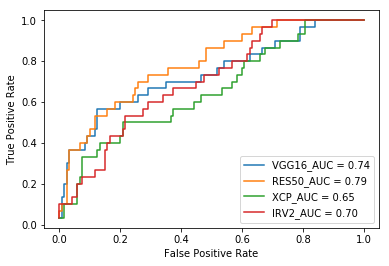

In [8]:
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    for m in models: 
        plt.plot(fp1[m],tp1[m],label=str(m)+'_AUC = %0.2f' % ac1[m])

    plt.legend(loc="lower right")
    plt.show()

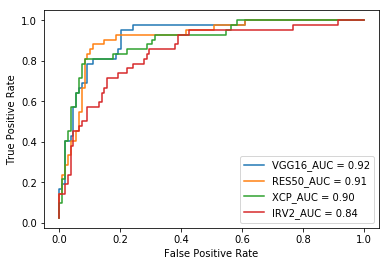

In [9]:
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    for m in models: 
        plt.plot(fp2[m],tp2[m],label=str(m)+'_AUC = %0.2f' % ac2[m])

    plt.legend(loc="lower right")
    plt.show()

In [10]:
#level1_features = np.hstack( (pr['VGG16'],pr['RES50']) )
level1_features = np.hstack( ([pr[m] for m in models]) )

In [11]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(C=0.01)
lgr=LogisticRegression(C=0.11)


lgr.fit(level1_features,d2['labels'])

LogisticRegression(C=0.11, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
jj = lgr.predict_proba(level1_features)
lgr.score(level1_features,d2['labels'])

0.7666666666666667

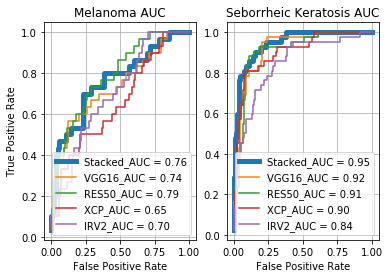

In [13]:
tpr,fpr,roc_auc = calc_roc(jj,d2['labels'],prob_loc=0,pos_label=0)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.plot(fpr,tpr,linewidth=5.0,label='Stacked_AUC = %0.2f' % roc_auc)
    
for m in models: 
        ax1.plot(fp1[m],tp1[m],label=str(m)+'_AUC = %0.2f' % ac1[m])

ax1.grid(True)
ax1.legend(loc="lower right")
ax1.set_title("Melanoma AUC")
        

tpr,fpr,roc_auc = calc_roc(jj,d2['labels'],prob_loc=2,pos_label=2)
    
ax2.set_xlabel('False Positive Rate')
ax2.plot(fpr,tpr,linewidth=5.0,label='Stacked_AUC = %0.2f' % roc_auc)
    
for m in models: 
        ax2.plot(fp2[m],tp2[m],label=str(m)+'_AUC = %0.2f' % ac2[m])

ax2.grid(True)
ax2.legend(loc="lower right",fontsize='x-small')
ax2.set_title("Seborrheic Keratosis AUC")
ax2.legend(loc="lower right")

plt.show()    

fig.savefig('Models_valid_Stacked_AUC_plots.jpeg',dpi=600)
  

[[ 67  28  22]
 [ 71 235  87]
 [ 13  14  63]]
for model  VGG16
AUC_0= 0.7643467643467643
AUC_2= 0.8216775599128541
[[ 58  28  31]
 [ 66 255  72]
 [  6  10  74]]
for model  RES50
AUC_0= 0.7717435543522501
AUC_2= 0.8786056644880175
[[ 55  29  33]
 [ 72 244  77]
 [ 11   8  71]]
for model  XCP
AUC_0= 0.7615508485073702
AUC_2= 0.8248366013071895
[[ 47  37  33]
 [ 47 267  79]
 [ 13  13  64]]
for model  IRV2
AUC_0= 0.7376616941834333
AUC_2= 0.828082788671024


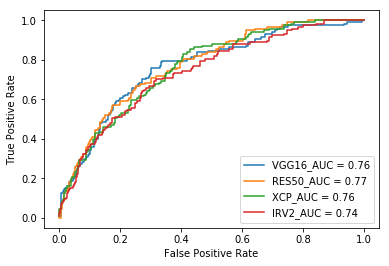

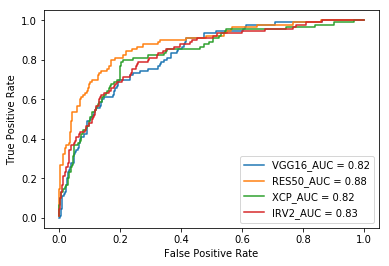

In [14]:
#calculate the level 1 features for Test Data

for m in models:
    d2 = np.load('Sq_orig_test_features_ISIC_'+ str(m))

    probs = model_store[m].predict(d2['features'],batch_size=128,verbose=0)
    
    tpr,fpr,roc_auc = calc_roc(probs,d2['labels'],prob_loc=0,pos_label=0)
    print (confusion_matrix(d2['labels'], np.argmax(probs[:,],axis=1))   )
    
    print ('for model ',m)
    print ( 'AUC_0=',roc_auc)
    fp1[m] = fpr[0:]
    tp1[m] = tpr[0:]
    ac1[m] = roc_auc

    tpr,fpr,roc_auc = calc_roc(probs,d2['labels'],prob_loc=2,pos_label=2)
    
    print ( 'AUC_2=',roc_auc)
                        
    hist[m] = history
    fp2[m] = fpr[0:]
    tp2[m] = tpr[0:]
    pr[m] = probs[:,:]
    ac2[m] = roc_auc

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for m in models: 
        plt.plot(fp1[m],tp1[m],label=str(m)+'_AUC = %0.2f' % ac1[m])

plt.legend(loc="lower right")
plt.show()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
for m in models: 
        plt.plot(fp2[m],tp2[m],label=str(m)+'_AUC = %0.2f' % ac2[m])

plt.legend(loc="lower right")
plt.show()
    

In [15]:
level1_test_features = np.hstack( ([pr[m] for m in models]) )

lgr_probs = lgr.predict_proba(level1_test_features)
lgr.score(level1_test_features,d2['labels'])

0.7016666666666667

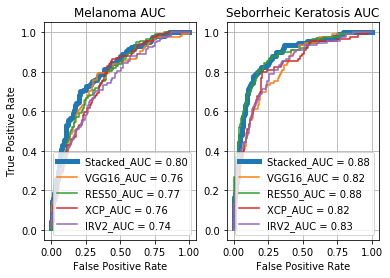

In [16]:
tpr,fpr,roc_auc = calc_roc(lgr_probs,d2['labels'],prob_loc=0,pos_label=0)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.plot(fpr,tpr,linewidth=5.0,label='Stacked_AUC = %0.2f' % roc_auc)
    
for m in models: 
        ax1.plot(fp1[m],tp1[m],label=str(m)+'_AUC = %0.2f' % ac1[m])

ax1.grid(True)
ax1.legend(loc="lower right")
ax1.set_title("Melanoma AUC")
        

tpr,fpr,roc_auc = calc_roc(lgr_probs,d2['labels'],prob_loc=2,pos_label=2)
    
ax2.set_xlabel('False Positive Rate')
ax2.plot(fpr,tpr,linewidth=5.0,label='Stacked_AUC = %0.2f' % roc_auc)
    
for m in models: 
        ax2.plot(fp2[m],tp2[m],label=str(m)+'_AUC = %0.2f' % ac2[m])

ax2.grid(True)
ax2.legend(loc="lower right",fontsize='x-small')
ax2.set_title("Seborrheic Keratosis AUC")
ax2.legend(loc="lower right")

plt.show()    

fig.savefig('Models_Stacked_AUC_plots.jpeg',dpi=600)
  


In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(validation_labels, np.argmax(probs[:,],axis=1))

array([[ 47,  37,  33],
       [ 47, 267,  79],
       [ 13,  13,  64]])